In [1]:
import sys
sys.path.append('..')

from olfactory_navigation import Environment, Agent
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

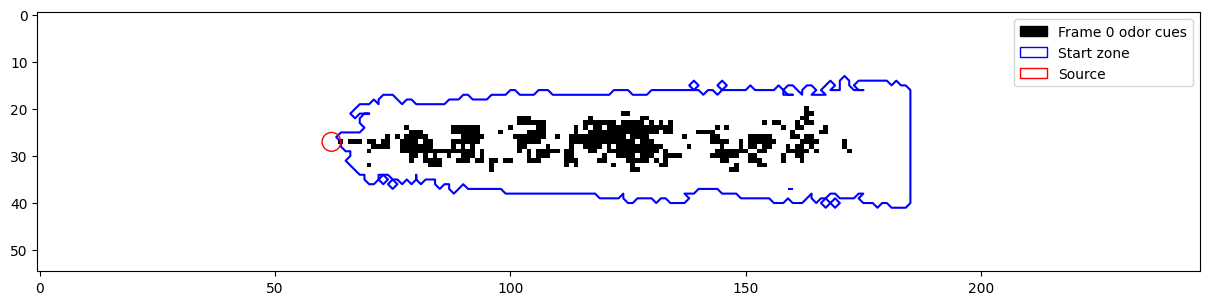

In [3]:
# data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH
data_path = "G:\\My Drive\\Documents\\Universita di Genova\\Pimlb work\\nose_data_27_123.h5"

env = Environment(data_file=data_path,
                  data_source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

In [4]:
ag = FSVI_Agent(env)

[Warning] The whole dataset is being querried, it will be reshaped at this time. To avoid this, avoid querrying environment.data directly.


In [5]:
_ = ag.train(expansions=10, use_gpu=True)

[07/22/2024, 23:40:54] MDP_policy, not provided. Solving MDP with Value Iteration...
[07/22/2024, 23:40:54] Sending Model to GPU...
[07/22/2024, 23:40:55]     > Done in 1.425s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 1.8658 seconds
  - Took on average 0.0020s per iteration


Expansions:   0%|          | 0/10 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 13585 state, 4 action, 3 observations
  - Converged or stopped after 10 expansion steps and 10 backup steps.
  - Resulting value function has 36 alpha vectors.
  - Converged in 12.8576s

  - Expand function took on average 0.7075s and yielded on average 47.30 beliefs per iteration. (0.0682s/it/belief)
  - Backup function took on average 0.5783s and yielded on average 3.20 alpha vectors per iteration. (0.1138s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


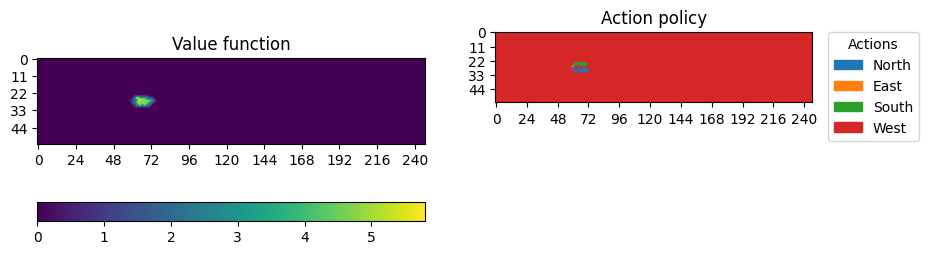

In [6]:
ag.value_function.plot()

In [7]:
# ag.save(force=False, save_environment=False)

In [8]:
hist = run_all_starts_test(ag, use_gpu=True)
# hist = run_test(n=100, agent=ag, time_shift=2400, use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 80.423s:
Simulations reached goal: 1864/2393 (529 failures (reached horizon: 529)) (77.89% success)
 - Average step count:                 291.159 +- 379.70 (Successfull only: 89.991 +- 45.01)
 - Extra steps:                        220.126 +- 393.92 (Successful only: 10.732 +- 27.39)
 - Average discounted rewards (ADR):   0.346 +- 0.25 (Successfull only: 0.445 +- 0.19)
 - Tmin/T:                             0.731 +- 0.38 (Successful only: 0.926 +- 0.12)


In [9]:
hist.analysis_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,discounted_rewards,extra_steps,t_min_over_t
mean,NaN,NaN,NaN,0.778939,0.221061,291.159214,0.346491,220.125784,0.730559
standard_deviation,NaN,NaN,NaN,0.414962,0.414962,379.701458,0.249797,393.918152,0.382579
success_mean,NaN,NaN,NaN,1.0,0.0,89.991416,0.444813,10.732296,0.925957
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,45.010739,0.190778,27.392060,0.122807
run_0,14.0,171.0,120.0,True,False,152.000000,0.217045,32.000000,0.789474
...,...,...,...,...,...,...,...,...,...
run_2388,40.0,178.0,127.0,True,False,127.000000,0.279042,0.000000,1.000000
run_2389,40.0,181.0,130.0,True,False,130.000000,0.270754,0.000000,1.000000
run_2390,40.0,182.0,131.0,True,False,131.000000,0.268047,0.000000,1.000000
run_2391,40.0,183.0,132.0,True,False,132.000000,0.265366,0.000000,1.000000


In [10]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_2393-20240722_234112-horizon_1000.csv
Simulation's analysis saved to: ./Simulations-s_55_247-n_2393-20240722_234112-horizon_1000-analysis.csv


In [2]:
loaded_hist = SimulationHistory.load_from_file('./Simulations-s_55_247-n_2393-20240722_234112-horizon_1000.csv')

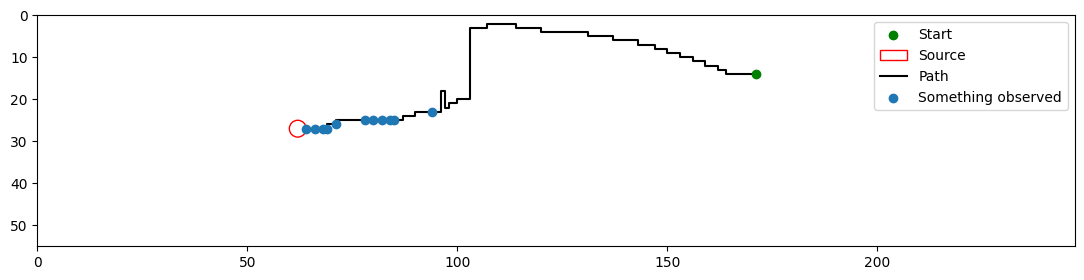

In [3]:
loaded_hist.plot()

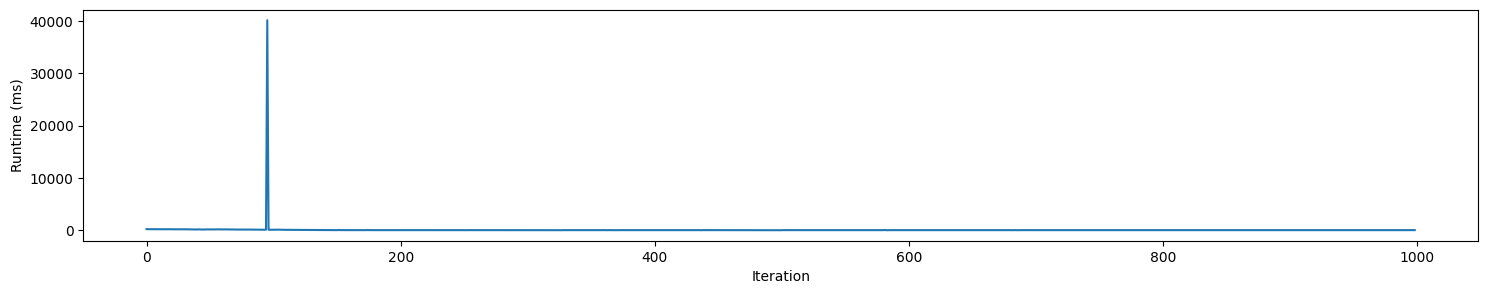

In [12]:
loaded_hist.plot_runtimes()

In [15]:
hist2 = SimulationHistory.load_from_file('./Simulations-s_55_247-n_2393-20240717_232141-horizon_1000.csv', environment=env, agent=ag)

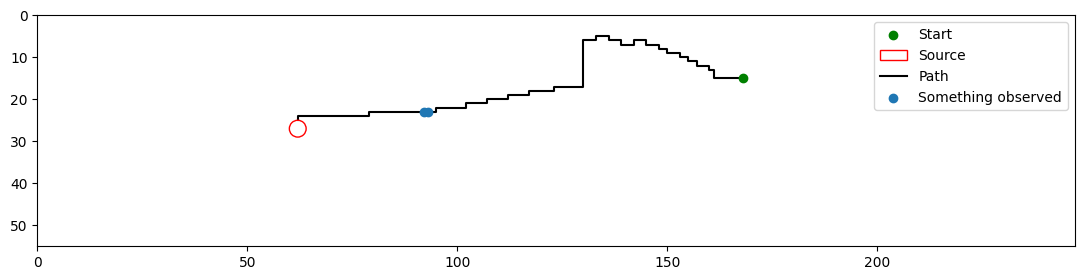

In [17]:
hist2.plot(3)